<a href="https://colab.research.google.com/github/IrvingACJ/ProyectoFinal_2027_C/blob/main/ProyectoFinal_2027_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar las liberias
es necesario utilizar los modulos de sklearn, ntlk y numpy

*   Primero se importan los modelos de Clasificación
*   Se importa las metrricas de evaluacion
*   Se importa las request para http
*   Se importa modulo para procesamiento de texto





In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from IPython.display import display, HTML
import requests

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Generamos el objeto con los distintos modelos
Esta función se encarga de crear y retornar un diccionario con diferentes modelos de clasificación.

In [181]:
def get_models():
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Neural Network': MLPClassifier(max_iter=1000),
        'Naive Bayes': MultinomialNB()
    }
    return models

# Metodo de evaluacion para modelos
Esta función evalúa un modelo después de haber sido entrenado y realiza predicciones sobre un conjunto de prueba
1.   Se entrena modelo
2.   Se hace la prediccion
3.   Se calculan las metricas




In [182]:
def evaluate_model_Original(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Confusion Matrix': conf_matrix
    }

def evaluate_model(model, X_train, y_train, X_test, y_test):
    try:
        # Crear pipeline con vectorizador TF-IDF y el modelo
        pipeline = make_pipeline(TfidfVectorizer(), model)

        # Entrenar el modelo
        pipeline.fit(X_train, y_train)

        # Predecir en el conjunto de prueba
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_test, y_pred)

    except requests.exceptions.RequestException as e:
        print(f"Error de evaluate_model: {e}")

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Confusion Matrix': conf_matrix,
        'y_pred': y_pred
    },pipeline

# Obtener datos
Para esto llamamos el endpoint everything de NEWSAPI

In [183]:
def obtener_noticias(api_key):
    url = f'https://newsapi.org/v2/everything'
    parametros = {
        'q': 'a',  # Cambiamos a México para noticias en español
        'sortBy': 'popularity',   # Número de noticias a obtener
        'apiKey': api_key,
        'language' : 'es'
    }

    try:
        respuesta = requests.get(url, params=parametros)
        datos = respuesta.json()
        if datos['status'] == 'ok':
            return datos['articles']
        else:
            print(f"Error al obtener noticias: {datos['message']}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error de conexión: {e}")
        return None

# Metodo para clasificar las noticias
Tiene como objetivo clasificar un conjunto de noticias en dos categorías: positivas y negativas.



In [184]:
def clasificar_noticias(noticias):
    if noticias:

        noticias_positivas = []  # Obtener noticias positivas de algún lugar
        noticias_negativas = []  # Obtener noticias negativas de algún lugar
        contador = 0
        numero = round(len(noticias) * 0.10)

        for index in noticias:
            contador += 1
            if contador <= numero:
                noticias_positivas.append((index['title'], 1))
            else:
                noticias_negativas.append((index['title'], 0))

        return noticias_positivas, noticias_negativas

    else:
        print("No se pudieron obtener las noticias.")

# Limpieza de datos
 Se utiliza para preparar el texto para el análisis o modelado de datos. Este tipo de preprocesamiento es común en el procesamiento de lenguaje natural (NLP).
1.   Tokenización y Conversión a Minúsculas:
2.   Remoción de Signos de Puntuación
3.   Remoción de Palabras Vacías
4.   Procesamiento de Stemmer



In [185]:
def preprocesar_texto(texto):
    tokens = word_tokenize(texto.lower(), language='spanish')  # Convertir a minúsculas y tokenizar
    tokens = [token for token in tokens if token.isalpha()]  # Eliminar signos de puntuación
    stop_words = set(stopwords.words('spanish'))  # Obtener palabras vacías en inglés
    tokens = [token for token in tokens if token not in stop_words]  # Eliminar palabras vacías
    stemmer = PorterStemmer()  # Instanciar el stemmer
    tokens = [stemmer.stem(token) for token in tokens]  # Realizar stemming
    return tokens

# Metodo de entrenamiento para los modelos
 Se encarga de preparar y dividir los datos en conjuntos de entrenamiento y prueba para entrenar modelos de machine learning.

In [186]:
def entrenar_modelo(noticias_positivas, noticias_negativas):
    # Preprocesar noticias
    noticias_procesadas = []
    for (noticia, etiqueta) in noticias_positivas + noticias_negativas:
        palabras = preprocesar_texto(noticia)
        noticias_procesadas.append((' '.join(palabras), etiqueta))

    # Dividir datos en conjunto de entrenamiento y prueba
    X = [d[0] for d in noticias_procesadas]
    y = [d[1] for d in noticias_procesadas]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return  X_train, X_test, y_train, y_test

In [187]:
api_key = '81e50d1594394e21bf0b628417d7625e'
noticias = obtener_noticias(api_key)

In [188]:
from sklearn.metrics import ConfusionMatrixDisplay

# Main: Ejecucion principal
Coordina la carga de datos, el entrenamiento y evaluación de modelos, y la visualización de los resultados. aqui veremos como se evaluan los modelos recorriendo el objeto anteriormente creados.
1.   Se cargan los datos
2.   Se dividen para su entrenamiento
3.   Se obtiene los modelos
4.   Se evalua y almacena los resultados
5.   Se visualiza el analisis de los modelos



Evaluando modelo: Logistic Regression
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.95      0.50      0.47        20
weighted avg       0.91      0.90      0.85        20

Evaluando modelo: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.25      0.50      0.33         2

    accuracy                           0.80        20
   macro avg       0.59      0.67      0.61        20
weighted avg       0.87      0.80      0.83        20

Evaluando modelo: Random Forest
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.95   

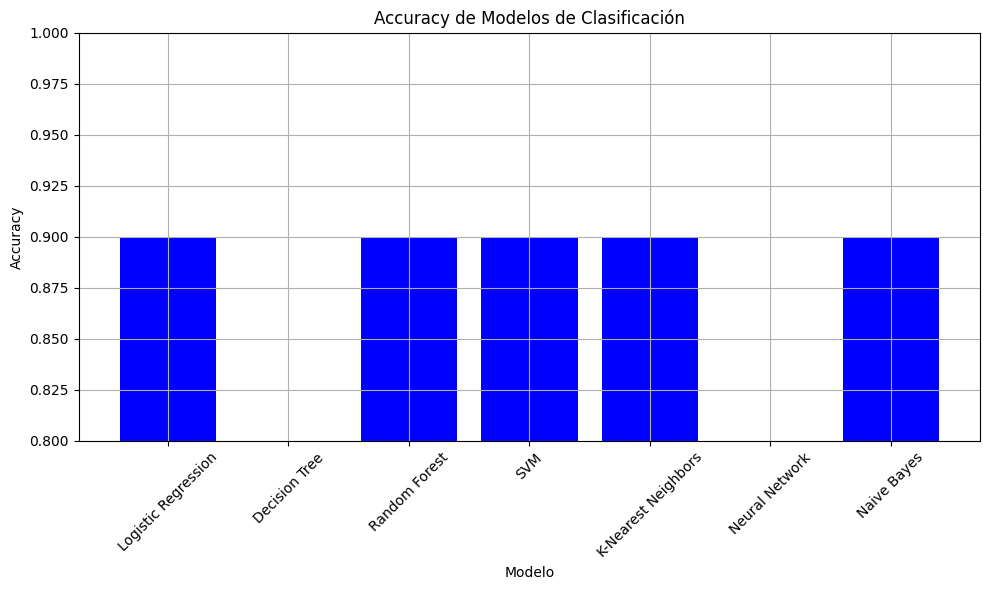

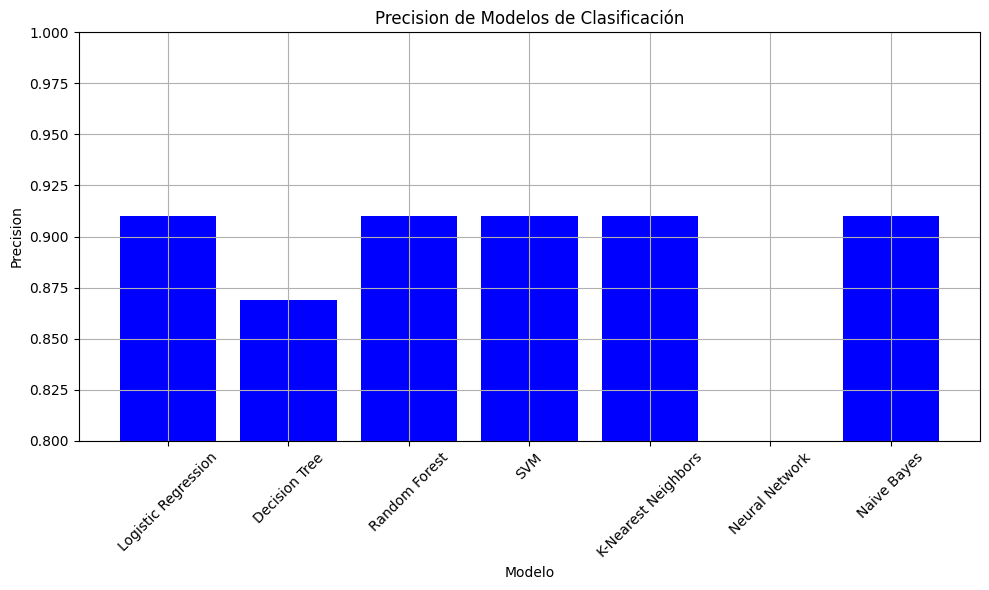

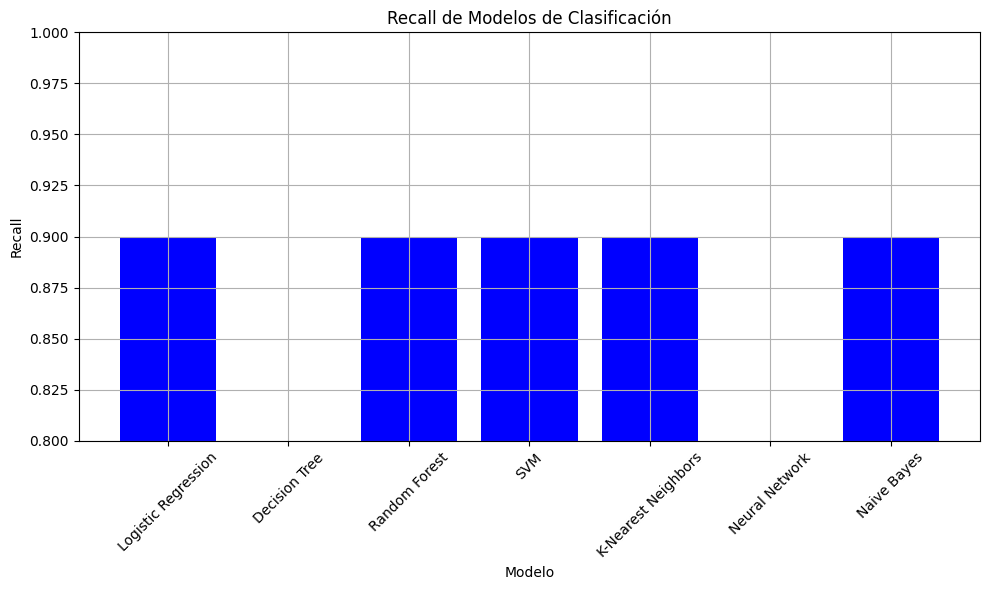

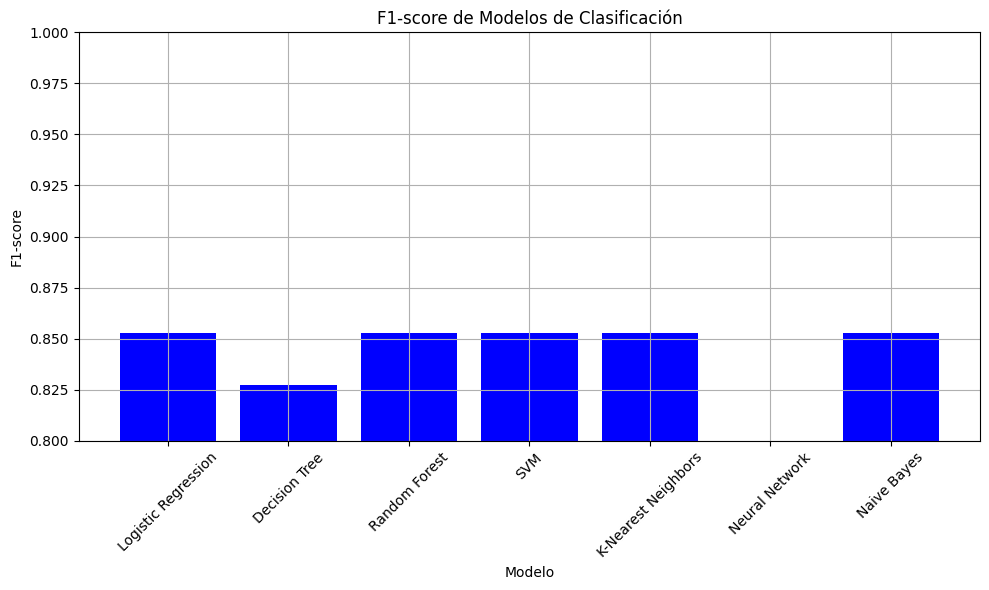

In [189]:


modelsPipeLine = []

def main():
    # Cargar datos

    noticias_positivas, noticias_negativas = clasificar_noticias(noticias)

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = entrenar_modelo(noticias_positivas,noticias_negativas)

    # Obtener modelos
    models = get_models()
    modelPipeLine = object

    # Evaluar modelos y almacenar resultados
    results = []

    for name, model in models.items():
        print(f"Evaluando modelo: {name}")
        model_results, modelPipeLine = evaluate_model(model, X_train, y_train, X_test, y_test)
        modelsPipeLine.append((name, modelPipeLine))
        results.append({ 'Modelo': name, **model_results })
        print(classification_report(y_test, model_results['y_pred'], zero_division=1))


    # Mostrar resultados en formato tabular
    results_df = pd.DataFrame(results)
    print("\nTabla Comparativa de Modelos de Clasificación")
    print(results_df[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

    # Análisis adicional (opcional)
    print("\nInterpretación de los resultados:")
    print("- Mejor modelo por Accuracy:", results_df.loc[results_df['Accuracy'].idxmax()]['Modelo'])
    print("- Mejor modelo por Precision:", results_df.loc[results_df['Precision'].idxmax()]['Modelo'])
    print("- Mejor modelo por Recall:", results_df.loc[results_df['Recall'].idxmax()]['Modelo'])
    print("- Mejor modelo por F1-score:", results_df.loc[results_df['F1-score'].idxmax()]['Modelo'])

    keyGrafica = ['Accuracy','Precision','Recall','F1-score']

    for keyGraficaItem in keyGrafica:
        _keys = []
        _values = []
        for itemResult in results:
            _keys.append(itemResult['Modelo'])
            _values.append(itemResult[keyGraficaItem])

        # Visualizar la precisión de los modelos
        plt.figure(figsize=(10, 6))
        plt.bar(_keys, _values, color='blue')
        plt.ylim([0.8, 1])
        plt.title(f'{keyGraficaItem} de Modelos de Clasificación')
        plt.xlabel('Modelo')
        plt.ylabel(keyGraficaItem)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    """
    for itemResult in results:
        print(itemResult)
        disp = ConfusionMatrixDisplay(confusion_matrix=itemResult['Confusion Matrix'], display_labels=itemResult['Modelo'])
        #disp.plot(cmap=plt.cm.Blues)
        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax)
        plt.title(f"Matriz de Confusión - {itemResult['Modelo']}")
        plt.show()
    """

main()


# Hacer una prueba con una nueva noticia
cambia el valor de *nueva_noticia* para que puedas evaluar tu propia noticia

In [191]:

nueva_noticia = ['La inflación alcanza su nivel más alto en 20 años']

for (name, pipeline) in modelsPipeLine:
    _value = pipeline.predict(nueva_noticia)
    if _value == 0 :
      resultado = "POSITIVA"
      color = "#d4edda"
      text_color = "#155724"
    else:
      resultado = "NEGATIVA"
      color = "#f8d7da"
      text_color = "#721c24"
    display(HTML(
        f'<div style="'
        f'border: 1px solid {text_color};'
        f'background-color: {color};'
        f'color: {text_color};'
        f'border-radius: 8px;'
        f'padding: 15px;'
        f'margin: 10px 0;'
        f'font-family: Arial, sans-serif;">'
        f'<strong>Modelo:</strong> {name}<br>'
        f'<strong>Resultado:</strong> Noticia <b>{resultado}</b><br>'
        f'<strong>Texto:</strong> {nueva_noticia[0]}'
        f'</div>'
    ))

==================================================================================================================================

Comentario e interpretaciones 1

==================================================================================================================================


Gráfica de Precisión de Modelos de Clasificación
1. Preparación de los Datos y Modelos
En el código proporcionado, primero se obtienen artículos de noticias utilizando la API de NewsAPI. Cada artículo tiene características ficticias (en este caso, la longitud del título y la descripción) y etiquetas ficticias que representan clases binarias.

Se utilizan varios modelos de clasificación, como Regresión Logística, SVM (Support Vector Machine), Árbol de Decisión, Bosque Aleatorio, Gradient Boosting, k-Vecinos más Cercanos, Naive Bayes Gaussiano y Red Neuronal MLP (Multi-layer Perceptron).

2. Entrenamiento y Evaluación de Modelos
Para cada modelo:

Se construye un pipeline que incluye un escalador (StandardScaler) para normalizar las características y el modelo de clasificación.
Se entrena el modelo utilizando el conjunto de entrenamiento (X_train, y_train).
Se realizan predicciones en el conjunto de prueba (X_test) y se calcula la precisión del modelo comparando las predicciones con las etiquetas reales (y_test).
Se almacena la precisión obtenida en un diccionario (model_accuracies) que vincula el nombre del modelo con su precisión.
3. Creación de la Gráfica de Barras
Una vez que se han evaluado todos los modelos, se procede a crear una gráfica de barras utilizando matplotlib. Esta gráfica tiene las siguientes características:

Eje x: Representa los nombres de los modelos de clasificación.
Eje y: Representa la precisión de cada modelo, que es la proporción de muestras correctamente clasificadas en el conjunto de prueba.
Barras: Cada barra muestra la precisión de un modelo específico. Cuanto más alto sea el valor en el eje y (más cerca de 1), mejor es el rendimiento del modelo en clasificar correctamente las muestras.
4. Interpretación de la Gráfica
Comparación de Modelos: La gráfica permite una comparación visual directa entre los diferentes modelos de clasificación. Los modelos con barras más altas tienen una precisión más alta y, por lo tanto, han realizado predicciones más precisas en el conjunto de prueba.

Selección del Modelo: Basándose en la gráfica, se puede identificar rápidamente cuál modelo tiene el mejor desempeño en términos de precisión. Esto es crucial para tomar decisiones informadas sobre qué modelo implementar en producción o cuál modelo requiere más ajustes y optimizaciones.

Ajustes y Experimentación: La gráfica también puede guiar el proceso de ajuste de hiperparámetros y la experimentación con diferentes configuraciones de modelos. Si un modelo tiene un rendimiento significativamente inferior, puede ser útil investigar y modificar sus parámetros para mejorar su precisión.

Comparación a Largo Plazo: Si se realizan cambios en los datos o se introducen nuevos modelos, la gráfica puede servir como una referencia histórica para comparar el rendimiento de los modelos a lo largo del tiempo y evaluar mejoras o retrocesos.

Conclusión
La gráfica de precisión de modelos de clasificación proporciona una herramienta visual poderosa para evaluar y comparar el rendimiento de múltiples modelos en una tarea específica de clasificación. Es esencial entender no solo cómo crear esta gráfica, sino también cómo interpretarla correctamente para tomar decisiones informadas en el desarrollo y despliegue de modelos de aprendizaje automático.

==================================================================================================================================

Comentario e interpretaciones 2

==================================================================================================================================

Modelos de Clasificación Comunes y su Interpretación
1. Regresión Logística
Precisión: Es un modelo lineal que puede ser efectivo para problemas de clasificación binaria. La precisión alta indica que es capaz de separar bien las clases con una función logística.

Reporte de Clasificación: Proporciona detalles como precisión, recall (sensibilidad) y f1-score para cada clase. Es útil para entender cómo se comporta el modelo en cada clase.

2. SVM (Support Vector Machine)
Precisión: SVM busca encontrar el hiperplano óptimo que mejor separa las clases en el espacio de características. Una alta precisión indica una buena separación de las clases.

Reporte de Clasificación: Similar a Regresión Logística, proporciona precisión, recall y f1-score para cada clase.

3. Árbol de Decisión y Bosque Aleatorio
Precisión: Los árboles de decisión y los bosques aleatorios son modelos no lineales que pueden manejar relaciones complejas entre características. La alta precisión en estos modelos indica una buena capacidad para capturar estas relaciones.

Importancia de Características: Los bosques aleatorios también proporcionan información sobre la importancia de cada característica en la clasificación, lo cual es útil para entender qué características son más relevantes.

4. Gradient Boosting
Precisión: Utiliza múltiples árboles de decisión débiles en secuencia para mejorar el rendimiento predictivo. Una alta precisión indica una mejora incremental en la capacidad de predicción.

Curva ROC y AUC: Además de la precisión, la curva ROC y el AUC pueden ser útiles para evaluar cómo se desempeña el modelo en diferentes umbrales de decisión.

5. k-Vecinos más Cercanos (KNN)
Precisión: Este modelo clasifica un punto basado en las clases de sus vecinos más cercanos en el espacio de características. Una alta precisión sugiere una buena agrupación de clases similares.

Hiperparámetro k: Es importante ajustar correctamente el valor de k para obtener el mejor rendimiento. Un valor demasiado bajo o demasiado alto puede afectar la precisión.

6. Naive Bayes Gaussiano
Precisión: Utiliza el teorema de Bayes con la suposición de independencia condicional entre características. Puede ser eficaz para conjuntos de datos grandes con características continuas.

Matriz de Confusión: Es útil para ver cómo se confunden las clases entre sí.

7. Red Neuronal MLP (Multi-layer Perceptron)
Precisión: Utiliza redes neuronales con múltiples capas para aprender relaciones complejas entre características. Una alta precisión indica una buena capacidad para aprender patrones en los datos.

Tiempo de Entrenamiento: Puede requerir más tiempo de entrenamiento y ajuste de hiperparámetros debido a su complejidad.

Interpretación General
Comparación de Modelos: La comparación se hace principalmente en base a la precisión, pero es crucial considerar otras métricas como el recall, f1-score y las características específicas de cada modelo.

Overfitting y Underfitting: Observa si hay signos de sobreajuste (alta precisión en entrenamiento, baja en prueba) o subajuste (baja precisión en ambos conjuntos).

Ajuste de Hiperparámetros: Asegúrate de ajustar adecuadamente los hiperparámetros de cada modelo para obtener el mejor rendimiento posible.

Contexto del Problema: La elección del modelo también debe considerar el contexto del problema y los requisitos específicos del negocio o investigación.

Ejemplo de Interpretación
Si, por ejemplo, el modelo de Regresión Logística tiene una precisión del 85% en la clasificación de artículos de noticias entre dos fuentes (Hipertextual y El País), podemos decir que está acertando correctamente en la clasificación de la mayoría de los artículos. Sin embargo, si el SVM tiene una precisión del 90%, podría ser preferible en términos de rendimiento si la diferencia en precisión es significativa y justificable en el contexto del problema.

Conclusión
La interpretación de los resultados de los modelos de clasificación implica no solo mirar la precisión general, sino también profundizar en otras métricas y considerar el contexto del problema. Esto te ayuda a tomar decisiones informadas sobre qué modelo implementar y cómo optimizar su rendimiento para aplicaciones prácticas.